In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Đường dẫn đến dữ liệu
train_dir = '/kaggle/input/ai-1810-dpl-302-m-butterfly-image-classification/train/train'
test_dir = '/kaggle/input/ai-1810-dpl-302-m-butterfly-image-classification/test'
train_csv = '/kaggle/input/ai-1810-dpl-302-m-butterfly-image-classification/Training_set.csv'

# Đọc dữ liệu train từ CSV
df_train = pd.read_csv(train_csv)

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt


In [14]:
# Tạo ImageDataGenerator cho augmentation và preprocessing (chỉ áp dụng cho tập train)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,  # Thêm scale augmentation
    validation_split=0.2
)

# Tạo ImageDataGenerator cho tập validation (chỉ rescale, không augment)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Tạo generator cho dữ liệu train và validation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

Found 4000 validated image filenames belonging to 75 classes.
Found 1000 validated image filenames belonging to 75 classes.


In [15]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Load mô hình GoogLeNet (InceptionV3) đã pre-trained trên ImageNet
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Đóng băng tất cả các lớp trước
for layer in base_model.layers:
    layer.trainable = False

# Mở khóa 2 lớp CNN cuối cùng để train lại
for layer in base_model.layers[-12:]:
    layer.trainable = True

# Xây dựng mô hình
x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(256, activation="relu")(x)
output_layer = Dense(75, activation="softmax")(x)  

model = Model(inputs=base_model.input, outputs=output_layer)

# Hiển thị mô hình
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_188 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_188   │ (None, 111, 111, 32)   │             96 │ conv2d_188[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_188            │ (None, 111, 111, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_189 (Conv2D)       │ (None, 109, 109, 32)   │          9,216 │ activation_188[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_189   │ (None, 109, 109, 32)   │             96 │ conv2d_189[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_189            │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_190 (Conv2D)       │ (None, 109, 109, 64)   │         18,432 │ activation_189[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_190   │ (None, 109, 109, 64)   │            192 │ conv2d_190[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_190            │ (None, 109, 109, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 54, 54, 64)     │              0 │ activation_190[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_191 (Conv2D)       │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_191   │ (None, 54, 54, 80)     │            240 │ conv2d_191[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_191            │ (None, 54, 54, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_192 (Conv2D)  

 Total params: 23,002,475 (87.75 MB)

 Trainable params: 1,593,419 (6.08 MB)

 Non-trainable params: 21,409,056 (81.67 MB)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000225),  # Set initial learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callback: Lưu lại mô hình tốt nhất dựa trên độ chính xác trên tập validation
checkpoint = ModelCheckpoint("best_model.keras", 
                             monitor="val_accuracy", 
                             save_best_only=True, 
                             mode="max", 
                             verbose=1)

# Callback: Giảm learning rate nếu validation loss không giảm
reduce_lr = ReduceLROnPlateau(monitor="val_loss", 
                              factor=0.5, 
                              patience=2, 
                              min_lr=1e-6, 
                              verbose=1)

# Callback: Dừng huấn luyện nếu mô hình không cải thiện sau nhiều epoch
early_stopping = EarlyStopping(monitor="val_accuracy", 
                               patience=6, 
                               restore_best_weights=True, 
                               verbose=1)

# Huấn luyện mô hình
history = model.fit(
    train_generator,
    epochs= 100,  # Increase epochs to let callbacks work
    validation_data=validation_generator,
    callbacks=[checkpoint, reduce_lr, early_stopping],  # Add callbacks
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.0885 - loss: 4.1133
Epoch 1: val_accuracy improved from -inf to 0.36900, saving model to best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.0895 - loss: 4.1074 - val_accuracy: 0.3690 - val_loss: 2.7717 - learning_rate: 2.2500e-04
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.3292 - loss: 2.7040
Epoch 2: val_accuracy improved from 0.36900 to 0.60300, saving model to best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 700ms/step - accuracy: 0.3301 - loss: 2.6998 - val_accuracy: 0.6030 - val_loss: 1.7152 - learning_rate: 2.2500e-04
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.5418 - loss: 1.7517
Epoch 3: val_accuracy improved from 0.60300 to 0.67200, saving model to best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 707ms/step - accuracy: 0.5421 - loss: 1.7504 - val_accuracy: 0.6720 - val_loss: 1.2444 - learning_rate: 2.2500e-04
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step

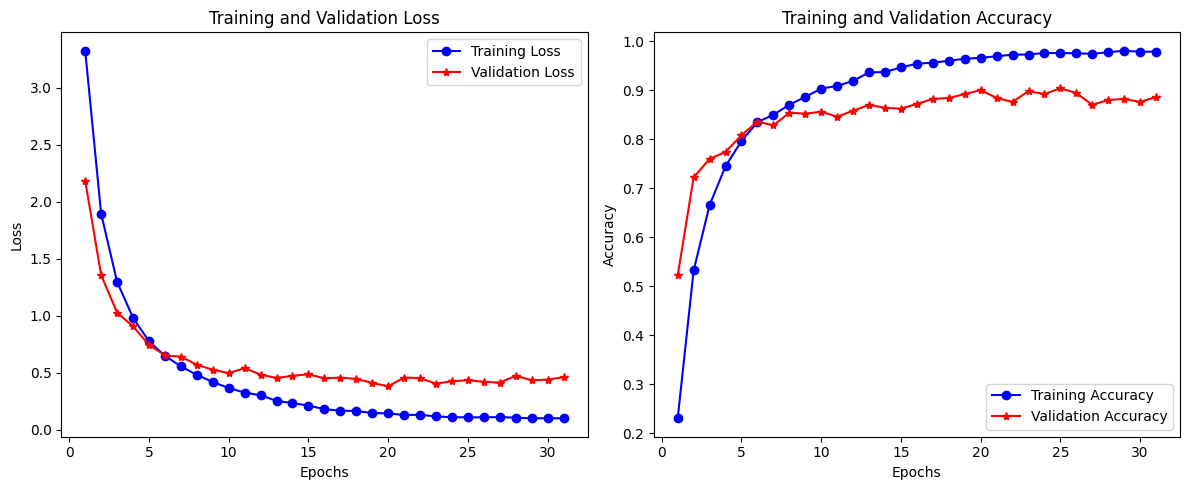

In [6]:
import matplotlib.pyplot as plt

# Lấy dữ liệu từ history
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict.get('accuracy')  # Kiểm tra nếu accuracy tồn tại
val_accuracy = history_dict.get('val_accuracy')  # Kiểm tra nếu val_accuracy tồn tại

epochs = range(1, len(loss) + 1)

# Vẽ biểu đồ loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Vẽ biểu đồ accuracy nếu có
if accuracy and val_accuracy:
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r*-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()


In [7]:
# Đọc dữ liệu test và dự đoán
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,  # Predict one image at a time
    class_mode=None,  # No labels for test data
    shuffle=False  # Important for maintaining order
)

#load best model
model = keras.models.load_model("best_model.keras")

# Dự đoán trên tập test
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)

# Mapping số lớp sang tên loài bướm
class_indices = train_generator.class_indices  # {'name1': 0, 'name2': 1, ...}
index_to_label = {v: k for k, v in class_indices.items()}  # Đảo ngược dict

# Chuyển class số sang tên bướm
predicted_labels = [index_to_label[idx] for idx in predicted_classes]

# Tạo submission file
filenames = test_generator.filenames
filenames = [filename.split('/')[-1] for filename in filenames]  # Extract filenames
df_submission = pd.DataFrame({'ID': filenames, 'label': predicted_labels})
df_submission.to_csv('submission.csv', index=False)

Found 1499 images belonging to 1 classes.
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step


In [8]:
df = pd.read_csv('/kaggle/working/submission.csv')
df

,ID,label
0,Image_1.jpg,SCARCE SWALLOW
1,Image_10.jpg,STRAITED QUEEN
2,Image_100.jpg,ULYSES
3,Image_1000.jpg,INDRA SWALLOW
4,Image_1001.jpg,MONARCH
...,...,...
1494,Image_995.jpg,MILBERTS TORTOISESHELL
1495,Image_996.jpg,CHECQUERED SKIPPER
1496,Image_997.jpg,CHESTNUT
1497,Image_998.jpg,DANAID EGGFLY
